# Analysis: Client DEAD

Included below is is an example of our inferential analysis using linear regression, applied to a random sample of 100,000 transactions from Iowa. We aim to produce a modeling process that can provide insights into the factors influencing alcohol purchasing behavior.

In this specific instance, given a dataset of transactions, we want to predict liters purchased per store in the year 2022. We will then evaluate the effect size of each variable to analyze alcohol purchasing factors

## Setup

In [119]:
!pip install sodapy
!pip install squarify

In [126]:
import pandas as pd
import numpy as np
import holidays
import datetime
import matplotlib.pyplot as plt
import altair as alt
import squarify
from sodapy import Socrata

# Data Collection

## Liquor Sales

In [58]:
# date_extract_dow() - 0 = Sunday, 6 = Saturday
client = Socrata("data.iowa.gov", None)
q = """
  select Date, date_extract_m(Date) as Month, date_extract_dow(Date) as DayOfWeek, name as StoreName, Zipcode, City, County, category_name, sale_liters, sale_dollars, state_bottle_retail
  where date_extract_y(date) >= 2022
  LIMIT 100000
"""
results = client.get("m3tr-qhgy", query=q)
df_liquor = pd.DataFrame.from_records(results)

## Colleges

In [59]:
url = "https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa"
df_colleges = pd.read_html(url)[0]

# Data Cleaning

## Functions

In [60]:
us_holidays = holidays.country_holidays('US', years=range(2012, 2024))
def near_holi(date):
  return int(bool(us_holidays[date - datetime.timedelta(weeks=2):date]))

In [61]:
def alc_type_cat(alc):
    alc_categories = {
        "VODKA": ["VODKA"],
        "WHISKY": ["WHISKY", "WHISKIES"],
        "RUM": ["RUM"],
        "GIN": ["GIN"],
        "TEQUILA": ["TEQUILA"],
        "BRANDY": ["BRANDIES", "BRANY"],
        "SCHNAPPS": ["SCHNAPPS"],
        "SPIRITS": ["SPIRITS"],
    }

    for category, keywords in alc_categories.items():
        for keyword in keywords:
          try:
            if keyword in alc:
                return category
          except:
            return "OTHER"
    return "OTHER"

In [62]:
def classify_college_size(enrollment):
    if enrollment > 10000:
        return "Large"
    elif enrollment > 3000:
        return "Midsize"
    else:
        return "Small"

## Feature Creation/Manipulation

In [63]:
df_colleges.rename(columns={"Location(s)[note 2]": "City"}, inplace=True)
df_colleges.rename(columns={"Enrollment[7] (spring 2012)": "Enrollment"}, inplace=True)
df_colleges = df_colleges[["Institution", "City", "Enrollment"]]
df_colleges["City"] = df_colleges["City"].str.upper()

In [64]:
df_liquor["sale_liters"] =df_liquor["sale_liters"].astype(float)
df_liquor["sale_dollars"] = df_liquor["sale_dollars"].astype(float)

In [65]:
df_liquor = df_liquor[df_liquor["sale_dollars"] > 0]
df_liquor = df_liquor[df_liquor["sale_dollars"] > 0]
df_liquor.dropna(subset=['City', 'Zipcode', 'County'], inplace=True)

In [66]:
df_liquor["Date"] = df_liquor["Date"].map(lambda date: datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f"))
df_liquor["NearHoliday"] = df_liquor["Date"].map(near_holi)
df_liquor["CostPerLiter"] = df_liquor["sale_dollars"] / df_liquor["sale_liters"]
df_liquor["Category"] = df_liquor["category_name"].map(alc_type_cat)
df_liquor["CategoryNum"] = df_liquor["Category"].map(
    {
        "VODKA": 1,
        "WHISKY": 2,
        "RUM": 3,
        "GIN": 4,
        "TEQUILA": 5,
        "BRANDY": 6,
        "SCHNAPPS": 7,
        "SPIRITS": 8,
        "OTHER": 9
      })
df_colleges["Student Pop"] = df_colleges["Enrollment"].str.replace(r"\[.*\]", "", regex=True)
df_colleges["Student Pop"] = df_colleges["Student Pop"].str.replace(",", "").astype(int)
student_pop = pd.DataFrame(df_colleges.groupby("City")["Student Pop"].sum())
college_count = pd.DataFrame(df_colleges.groupby("City")["Institution"].count())
student_pop = student_pop.merge(college_count, how="left", on="City")
student_pop["Size"] = student_pop["Student Pop"].apply(classify_college_size)
student_pop
# !!!Size is from 2012 data!!!
df_liquor = df_liquor.merge(student_pop, how="left", on="City")

In [67]:
df_liquor["Institution"].fillna(0, inplace=True)
df_liquor["Student Pop"].fillna(0, inplace=True)
df_liquor["Size"].fillna("None", inplace=True)

In [68]:
df_liquor['City'] = df_liquor['City'].astype("category")
df_liquor['County'] = df_liquor['County'].astype("category")
df_liquor['category_name'] = df_liquor['category_name'].astype("category")
df_liquor['StoreName'] = df_liquor['StoreName'].astype("category")
df_liquor['Size'] = df_liquor['Size'].astype("category")
df_liquor['Zipcode'] = df_liquor['Zipcode'].astype("category")

In [69]:
med = df_liquor["sale_liters"].astype(float).describe()["50%"]
df_liquor["Sale Amount"] = df_liquor["sale_liters"].map(lambda y: "Large" if y >= med else "Small")

# Save Data to CSV

In [70]:
df_liquor.to_csv("client_b", index=False)

# Model Fitting

## Data

In [71]:
df_liquor = pd.read_csv("https://raw.githubusercontent.com/mshsu/data403-project1/main/client_b", low_memory=False)

In [72]:
# Standardizing
df_liquor["CostPerLiter_std"] = (df_liquor["CostPerLiter"] - df_liquor["CostPerLiter"].mean()) / df_liquor["CostPerLiter"].std()
df_liquor["CategoryNum_std"] = (df_liquor["CategoryNum"] - df_liquor["CategoryNum"].mean()) / df_liquor["CategoryNum"].std()
df_liquor["StudentPop_std"] = (df_liquor["Student Pop"] - df_liquor["Student Pop"].mean()) / df_liquor["Student Pop"].std()
df_liquor["Institution_std"] = (df_liquor["Institution"] - df_liquor["Institution"].mean()) / df_liquor["Institution"].std()

## Functions

In [73]:
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def ridge(X, Y, l, intercept):
  """
  Inputs:
    X: numpy array of predictors
    y: numpy array of value to predict
    l: lambda
    intercept: boolean flag; true if intercept in model false if not

  Compute beta estimate(s) for Ridge regression
  """
  if intercept:
    ones_col = np.ones((X.shape[0], 1))
    X = np.hstack((ones_col, X))

  return np.linalg.inv(X.T @ X + l * np.identity(X.shape[1])) @ (X.T @ Y)
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def try_many_lambdas(X, Y, l_lst, intercept):
  """
  Computes Ridge estimators for a list of lambda values where:
    loss = Sq Error
  """
  df_results = pd.DataFrame(data={"lambda": l_lst})
  results = df_results["lambda"].apply(lambda l: ridge(X, Y, l, intercept))

  return pd.DataFrame(results.tolist())
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def tune_lambda_split(df_train, df_test, Y, l_lst, intercept, m_choice):
  """
  Compute chosen validation metric for a list of lambdas where:
    loss = Sq Error
  using test and training data

  Metric options:
    1: R-squared
    2: MSE
    3: MAE

  df_train: df of training data
  df_test: df of testing data
  Y: String with name of response
  m_choice: an list of int(s) corresonding metric(s)
  """
  X_train = df_train.drop([Y], axis=1)
  X_test = df_test.drop([Y], axis=1)
  Y_train = df_train[Y]
  Y_test = df_test[Y]

  df_results = try_many_lambdas(X_train.to_numpy(), Y_train.to_numpy(), l_lst, intercept)

  if intercept:
    X_test.insert(0, "b0", 1)

  df_results["y_hat"] = df_results.apply(lambda row: X_test.to_numpy() @ row.to_numpy(), axis=1)
  df_results["lambda"] = l_lst

  n = len(Y_test)
  keep = ["lambda"]
  if 1 in m_choice:
    df_results["r_sqr"] = df_results.apply(lambda row: 1 - sum((Y_test - row["y_hat"]) ** 2) / sum((Y_test - Y_test.mean()) ** 2), axis=1)
    keep.append("r_sqr")

  if 2 in m_choice:
    df_results["MSE"] = df_results.apply(lambda row: 1 / n * sum((Y_test - row["y_hat"]) ** 2), axis=1)
    keep.append("MSE")

  if 3 in m_choice:
    df_results["MAE"] = df_results.apply(lambda row: sum(abs(Y_test - row["y_hat"])) / n, axis=1)
    keep.append("MAE")

  return df_results[keep]
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def tune_lambda_cv(df, Y, l_lst, intercept, m_choice, n_split):
  """
  Compute avg chosen validation metric for a list of lambdas using v-fold cross-validation

  Metric options:
    1: R-squared
    2: MSE
    3: MAE

  df: Pandas DataFrame of ONLY predictors and response
  Y: String with name of response
  intercept: boolean flag; true if intercept in model false if not
  m_choice: an list of int(s) corresonding metric(s)
  """
  df = df.sample(frac=1, random_state=43)
  fold_size = len(df) // n_split
  df["Fold"] = np.append(np.repeat(range(1, n_split+1), fold_size), np.repeat(n_split,len(df) % n_split))

  df_results = pd.DataFrame()
  for n in range(1, n_split+1):
    df_test = df[df["Fold"] == n].drop(["Fold"], axis=1)
    df_train = df[df["Fold"] != n].drop(["Fold"], axis=1)
    df_results = pd.concat([df_results, tune_lambda_split(df_train, df_test, Y, l_lst, intercept, m_choice)])

  return df_results.groupby("lambda").mean()
# -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
def compare_B(B, X, Y):
  predictors = pd.DataFrame(X).columns.to_list()
  predictors.insert(0, "intercept")
  return pd.DataFrame({"B": ridge(X, Y, 10, True)}, index=predictors).sort_values("B", ascending=False)

## Models

### Model 0


In [74]:
df_m0 = df_liquor[['sale_liters', 'NearHoliday','CostPerLiter_std', 'CategoryNum_std', 'StudentPop_std', 'DayOfWeek']]
df_m0 = pd.get_dummies(df_m0, columns=["DayOfWeek"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m0, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.006959,1440.954040,7.909039
2,0.006959,1440.954004,7.908985
3,0.006959,1440.953971,7.908932
4,0.006959,1440.953940,7.908879
5,0.006959,1440.953911,7.908827
10,0.006960,1440.953780,7.908570
100,0.006961,1440.952302,7.904119
1000,0.006945,1440.985853,7.864697


#### Model 1

In [75]:
df_m1 = df_liquor[['sale_liters', 'NearHoliday', 'CostPerLiter_std', 'Institution_std', 'Category']]
df_m1 = pd.get_dummies(df_m1, columns=["Category"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m1, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.007700,1440.011053,7.898609
2,0.007700,1440.011031,7.898555
3,0.007700,1440.011010,7.898500
4,0.007700,1440.010989,7.898445
5,0.007700,1440.010968,7.898391
10,0.007700,1440.010866,7.898118
100,0.007701,1440.009767,7.893249
1000,0.007675,1440.049017,7.849157


### Model 2

In [76]:
df_m2 = df_liquor[['sale_liters', 'NearHoliday', 'CostPerLiter_std', 'CategoryNum_std', 'Institution_std']]

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m2, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.006543,1441.659193,7.848467
2,0.006543,1441.659192,7.848435
3,0.006543,1441.659191,7.848403
4,0.006543,1441.659189,7.848371
5,0.006543,1441.659188,7.848339
10,0.006543,1441.659183,7.848180
100,0.006543,1441.659337,7.845318
1000,0.006531,1441.680919,7.817114


### Model 3


In [77]:
df_m3 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Institution", "DayOfWeek", "County"]]
df_m3 = pd.get_dummies(df_m3, columns=["Month", "Category", "Institution", "DayOfWeek", "County", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m3, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.006436,1441.690045,8.182435
2,0.006440,1441.684839,8.181802
3,0.006443,1441.679774,8.181180
4,0.006447,1441.674843,8.180571
5,0.006451,1441.670039,8.179971
10,0.006468,1441.647738,8.177141
100,0.006595,1441.478604,8.145308
1000,0.006300,1441.898752,8.059024


### Model 4

In [78]:
df_m4 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Institution", "DayOfWeek"]]
df_m4 = pd.get_dummies(df_m4, columns=["Month", "Category", "Institution", "DayOfWeek", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m4, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.005076,1443.639799,8.096820
2,0.005076,1443.639587,8.096755
3,0.005077,1443.639384,8.096691
4,0.005077,1443.639190,8.096629
5,0.005077,1443.639001,8.096567
10,0.005078,1443.638111,8.096259
100,0.005086,1443.625993,8.090813
1000,0.005087,1443.624394,8.044913


### Model 5

In [79]:
df_m5 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday", "Institution"]]
df_m5 = pd.get_dummies(df_m5, columns=["Month", "Category", "Institution", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m5, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.004163,1444.913729,8.052948
2,0.004163,1444.913607,8.052891
3,0.004163,1444.913488,8.052834
4,0.004163,1444.913371,8.052777
5,0.004164,1444.913255,8.052720
10,0.004164,1444.912704,8.052436
100,0.004169,1444.906036,8.047544
1000,0.004158,1444.925782,8.008171


### Model 6

In [80]:
df_m6 = df_liquor[["sale_liters", "Month", "Size", "Category", "NearHoliday"]]
df_m6 = pd.get_dummies(df_m6, columns=["Month", "Category", "Size"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m6, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.004054,1445.010479,8.049351
2,0.004054,1445.010406,8.049299
3,0.004054,1445.010334,8.049248
4,0.004054,1445.010265,8.049196
5,0.004054,1445.010197,8.049144
10,0.004055,1445.009884,8.048886
100,0.004058,1445.007170,8.044433
1000,0.004042,1445.042980,8.006787


### Model 7

In [81]:
df_m7 = df_liquor[["sale_liters", "Month", "Category", "NearHoliday", "Institution"]]
df_m7 = pd.get_dummies(df_m7, columns=["Month", "Category", "Institution"])

l_lst = [1, 2, 3, 4, 5, 10, 100, 1000]
tune_lambda_cv(df_m7, "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.004078,1445.035760,8.037064
2,0.004078,1445.035650,8.037004
3,0.004078,1445.035542,8.036944
4,0.004078,1445.035436,8.036884
5,0.004078,1445.035333,8.036824
10,0.004078,1445.034845,8.036525
100,0.004083,1445.029551,8.031391
1000,0.004063,1445.058111,7.988296


# Final Model

In [82]:
df_final_model = df_liquor[['Sale Amount', 'sale_liters', 'NearHoliday', 'CostPerLiter_std', 'Institution_std', 'Category']]
df_final_model = pd.get_dummies(df_final_model, columns=["Category"])

l_lst = [1, 2, 3, 4, 5, 10, 20, 21, 100, 275, 278, 279, 1000, 1500]
tune_lambda_cv(df_final_model.drop(['Sale Amount'], axis=1), "sale_liters", l_lst, True, [1, 2, 3], 5)

,r_sqr,MSE,MAE
lambda,,,
1,0.007700,1440.011053,7.898609
2,0.007700,1440.011031,7.898555
3,0.007700,1440.011010,7.898500
4,0.007700,1440.010989,7.898445
5,0.007700,1440.010968,7.898391
10,0.007700,1440.010866,7.898118
20,0.007700,1440.010676,7.897573
21,0.007701,1440.010658,7.897518
100,0.007701,1440.009767,7.893249


In [99]:
X = df_final_model.drop(["Sale Amount", "sale_liters"], axis=1)
Y = df_final_model["sale_liters"]
X_np = X.to_numpy()
Y_np = Y.to_numpy()

B = ridge(X_np, Y_np, 100, True)
df_B = compare_B(B, X, Y)
df_B

,B
intercept,6.012856
Category_VODKA,3.563122
Category_RUM,2.925903
NearHoliday,2.114321
Category_SCHNAPPS,1.515519
Institution_std,1.049535
Category_WHISKY,0.655983
Category_OTHER,0.574633
Category_GIN,0.066007
Category_TEQUILA,0.007095


In [100]:
y_labels = {'Category_BRANDY': 'Brandy', 'Category_GIN': 'Gin',
            'Category_OTHER': 'Other Alcohol', 'Category_RUM': 'Rum',
            'Category_SCHNAPPS': 'Schapps', 'Category_SPIRITS': 'Spirits',
            'Category_TEQUILA': 'Tequila', 'Category_VODKA': 'Vodka',
            'Category_WHISKY': 'Whisky', 'CostPerLiter_std': 'Cost Per Liter',
            'Institution_std': 'Number of Colleges in City',
            'NearHoliday': 'Near Holiday', 'intercept': 'Intercept'}

df_B = df_B.reset_index()
df_B['index'] = df_B['index'].map(y_labels)

In [167]:
df_B['relative size'] = abs(df_B['B'] / df_B['B'].sum() * 100)
df_B['abs B'] = abs(df_B['B'])

,index,B,relative size,abs B
0,Intercept,6.012856,47.221674,6.012856
1,Vodka,3.563122,27.982803,3.563122
2,Rum,2.925903,22.978435,2.925903
3,Near Holiday,2.114321,16.604720,2.114321
4,Schapps,1.515519,11.902056,1.515519
5,Number of Colleges in City,1.049535,8.242475,1.049535
6,Whisky,0.655983,5.151734,0.655983
7,Other Alcohol,0.574633,4.512851,0.574633
8,Gin,0.066007,0.518383,0.066007
9,Tequila,0.007095,0.055724,0.007095


Text(0.5, 1.0, 'Relative Size of Coefficients')

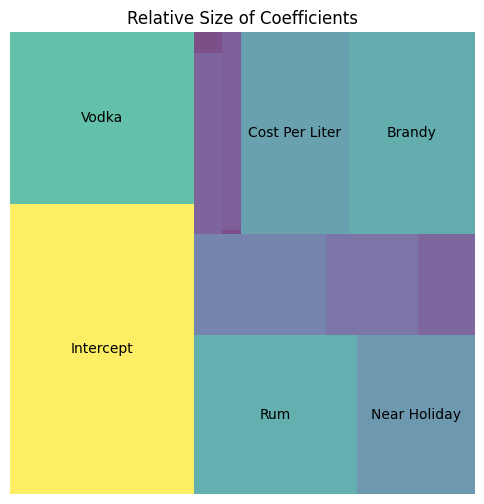

In [172]:
filtered_labels = [label if size >= 2 else '' for label, size in zip(df_B['index'], df_B['abs B'])]

norm = plt.Normalize(min(df_B['relative size']), max(df_B['relative size']))
colors = [plt.cm.viridis(norm(value)) for value in df_B['relative size']]
plt.figure(figsize=(6, 6))
squarify.plot(sizes=df_B['relative size'], label=filtered_labels, color=colors, alpha=0.7)
plt.axis('off')
plt.title('Relative Size of Coefficients')

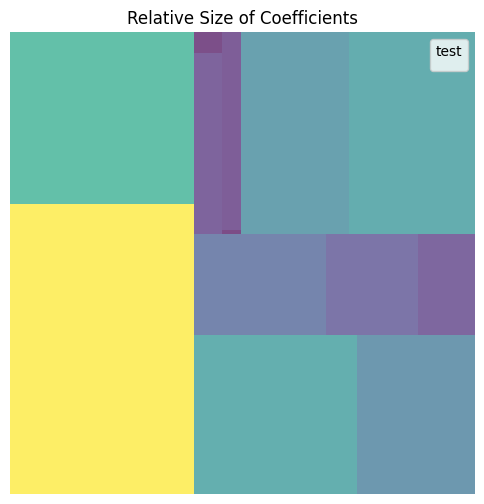

In [165]:
plt.figure(figsize=(6, 6))
cmap = plt.cm.viridis
norm = plt.Normalize(min(df_B['relative size']), max(df_B['relative size']))
colors = [cmap(norm(value)) for value in df_B['relative size']]
squarify.plot(sizes=df_B['relative size'], color=colors, alpha=0.7)
legend_labels = [f'{l}: {round(s, 2)}' for l, s in zip(df_B["index"].to_list(), df_B['B'].to_list())]
patches = plt.gca().patches
plt.legend(patches, legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.axis('off')
plt.title('Relative Size of Coefficients')
plt.legend(title='test')

In [115]:
alt.Chart(df_B, width=250, height=250).mark_circle().encode(
    y=alt.Y('index', title=''),
    size='B',
    color=alt.Color('B', title='Size of Coefficient')
).properties(
    title = "Size of Model Coefficients"
).configure_text(
    fontSize=2
)

alt.Chart(...)

# Sources

US Holidays: https://pypi.org/project/holidays/

In [30]:
us_holidays = holidays.country_holidays('US', years=2012)
for day in us_holidays.items():
    print(day)

(datetime.date(2012, 1, 16), 'Martin Luther King Jr. Day')
(datetime.date(2012, 2, 20), "Washington's Birthday")
(datetime.date(2012, 10, 8), 'Columbus Day')
(datetime.date(2012, 1, 1), "New Year's Day")
(datetime.date(2012, 1, 2), "New Year's Day (Observed)")
(datetime.date(2012, 5, 28), 'Memorial Day')
(datetime.date(2012, 7, 4), 'Independence Day')
(datetime.date(2012, 9, 3), 'Labor Day')
(datetime.date(2012, 11, 11), 'Veterans Day')
(datetime.date(2012, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2012, 11, 22), 'Thanksgiving')
(datetime.date(2012, 12, 25), 'Christmas Day')


Iowa Colleges: https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa